## Gawron Comments

This looks very good.  Good evaluation.  No comments on code, which is good.

# Sentiment Analysis for Amazon Reviews

Our goal is to build a sentiment analysis model that predicts whether the customer liked products sold by Amazon or not, based on their reviews on Amazon. I have build a simple text classifier using Python’s Pandas, NLTK and Scikit-learn libraries.

## The Dataset Overview

Amazon Reviews dataset was taken from Kaggle website(https://www.kaggle.com/bittlingmayer/amazonreviews).

This dataset consists of a few million Amazon customer reviews (input text) and star ratings (output labels) for sentiment analysis.

In this case, the classes are __label__1 and __label__2, and there is only one class per row.

__label__1 corresponds to 1- and 2-star reviews
__label__2 corresponds to 4- and 5-star reviews.

**Note** : (3-star reviews i.e. reviews with neutral sentiment were not included in the original)

This dataset had training set and test set provided by the data collector.


Training Set: 3.6M text reviews and ratings for training -> 1800000 reviews of label 1 and 1800000 reviews of label 2

Testing Set: 400K text reviews and ratings for testing -> 200000 reviews of label 1 and 200000 records for label 2

## Initial Cleaning

Because of the huge volume of the reviews in both training and test set and limited processing capability of my computer, it was taking long time to process and model on entire dataset. 

Hence, I have selected a subset from training and test set in order to complete this project on time. 

Training set consists of 10,000 reviews for label 1 and 10,000 reviews for label 2.

Testing set consists of 5000 reviews for label 1 and 5000 reviews for label 2.

Also, to avoid confusion between __label 1__ and __label 2__, I have recoded them as __neg__ and  __pos__ respectively.


## Importing the Dataset

Firstly, let’s import the necessary Python libraries. 

NLTK is pretty much the standard library in Python library for text processing, which has many useful features. For this project, I will just use NLTK for stopword removal.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics


import nltk
from nltk.corpus import stopwords

Next, importing Amazon reviews csv files of training and test set and storing these files in a Pandas dataframe called __train_data__ and __test_data__

In [40]:
#importing Amazon reviews which is stored in csv file and storing it in Pandas dataframe

train_data = pd.read_csv("train_neg_pos.csv")
test_data = pd.read_csv("test_neg_pos.csv")

Looking at some basic information about the data.

In [4]:
# Using method .info()

print train_data.info()
print test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
sentiment    20000 non-null object
review       20000 non-null object
dtypes: object(2)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
sentiment    10000 non-null object
review       10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB
None


In [5]:
# using method .shape to see the number of rows and columns in the dataframe
print train_data.shape
print test_data.shape

(20000, 2)
(10000, 2)


In [6]:
# using method .head() to see the top 5 entries of the dataframe
print train_data.head()
print test_data.head()

  sentiment                                             review
0       neg   Good tea/cheap chest: The tea assortment in t...
1       pos   Good program with nice graphics: I was able t...
2       neg   bloody awful: sounds like a third world eleme...
3       pos   An interesting toy: I saw this toy in Delhi b...
4       pos   The best album I've ever heard: I can't under...
  sentiment                                             review
0       neg   A Lite Alternative: Songs like "Follow My Way...
1       pos   F 451 shows how dangerous a person's ideas ar...
2       neg   Popping noise: Just bought these yesterday an...
3       neg   Defected Book!: 1 star because the book was d...
4       pos   A real suprise find at my public library: Jus...


In [7]:
#let's count how many labels do we have for each sentiment class in training and test. Though, checking test set is not required
print train_data.sentiment.value_counts()
print test_data.sentiment.value_counts()

pos    10000
neg    10000
Name: sentiment, dtype: int64
pos    5000
neg    5000
Name: sentiment, dtype: int64


To get an insight on the length of each review, we can create a new column in train_data called text length. This column will store the number of characters in each review.

In [8]:
train_data['text length'] = train_data['review'].apply(len)
train_data.head()

,sentiment,review,text length
0,neg,Good tea/cheap chest: The tea assortment in t...,254
1,pos,Good program with nice graphics: I was able t...,457
2,neg,bloody awful: sounds like a third world eleme...,248
3,pos,An interesting toy: I saw this toy in Delhi b...,349
4,pos,The best album I've ever heard: I can't under...,421


In the above cell, we can see the text length column in which was added in train_data

## Exploring the dataset

Visualising the data a little more by plotting some graphs with the Seaborn library.

Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

Seaborn’s FacetGrid allows us to create a grid of histograms placed side by side.

I am using FacetGrid to see if there’s any relationship between our newly created `text length` feature and the `stars` rating.

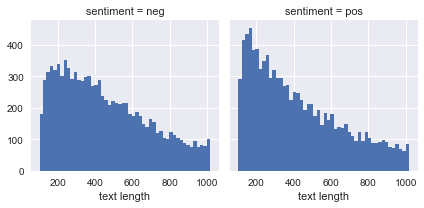

In [13]:
g = sns.FacetGrid(data=train_data, col='sentiment')
g.map(plt.hist, 'text length', bins=50)

From the above graph we can see that, the distribution of text length is similar across both positive and negative sentiments. 

Next, I have plotted a box plot of the `text length` for each `sentiment`

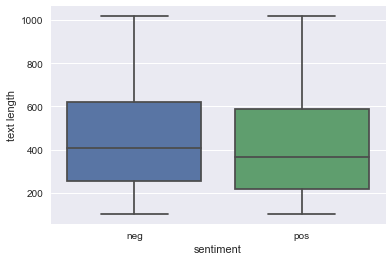

In [14]:
sns.boxplot(x='sentiment', y='text length', data=train_data)

From the above graph we can observe that the postive and negative sentiments have longer text.

## Independent and dependent variables

Next, let’s create the X and y for our classification task. X will be the review column of train_data, and y will be the sentiment column.

In [41]:
X = train_data['review']
y = train_data['sentiment']

## Text pre-processing

Since our data is in plain-text format, we face an issue.

The classification algorithm will need some sort of feature vector in order to perform the classification task. The simplest way to convert a corpus to a vector format is the bag-of-words approach, where each unique word in a text will be represented by one number.

First, let’s write a function that will split the review into its individual words, and return a list. 

We will also remove the very common words (such as “the”, “a”, “an”, etc.), also known as stopwords. To do this, we can take advantage of the NLTK library. The function below removes punctuation, stopwords, and returns a list of the remaining words, or tokens.

In [42]:
X[0]

' Good tea/cheap chest: The tea assortment in the chest is excellent, vey tasty. However, the chest is very poorly put together. The applique material does not line up and there are numerous rough edges. Not wht I would want to display on the countertop.\n'

In [43]:
import string

def text_process(text):
    '''
    This function takes in a string of text and then performs the following tasks:
    1. Remove all puncutations
    2. Remove all stopwords
    3. Return cleaned text as list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

#  Checking if the function works correctly
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."
print(text_process(sample_text))

['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


## Vectorization

To enable Scikit-learn algorithms to work on our text, we need to convert each review into a vector.

We can use Scikit-learn’s CountVectorizer to convert the text collection into a matrix of token counts.

Since there are many reviews, we can expect a lot of zero counts for the presence of a word in the collection. Because of this, Scikit-learn will output a __sparse matrix__.

Let’s import CountVectorizer and passing in our text_process function as the analyser.

In [44]:
bow_transformer = CountVectorizer(analyzer = text_process)

Fitting an instance to our review text (stored in X) and transforming our X dataframe into a sparse matrix. To do this, let’s use the .fit_transform() method on our bag-of-words transformed object.

In [45]:
# # applying the Count Vectorizer function on training set
X = bow_transformer.fit_transform(X)

C:\Users\Nikita\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  


We can check out the shape of our new X.

In [46]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print("Density: {}".format((density)))

('Shape of Sparse Matrix: ', (20000, 75112))
('Amount of Non-Zero occurrences: ', 724847)
Density: 0.0482510783896


In [47]:
X_test = test_data['review']
y_test = test_data['sentiment']

# applying the Count Vectorizer function on test set
X_test = bow_transformer.transform(X_test)

print('Shape of Sparse Matrix: ', X_test.shape)
print('Amount of Non-Zero occurrences: ', X_test.nnz)

# Percentage of non-zero values
density = (100.0 * X_test.nnz / (X_test.shape[0] * X_test.shape[1]))
print("Density: {}".format((density)))

C:\Users\Nikita\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  


('Shape of Sparse Matrix: ', (10000, 75112))
('Amount of Non-Zero occurrences: ', 338984)
Density: 0.0451304718287


## To evaluate the models performance

I have included below function to evaluate models performance based on precision, recall and accuracy provided by the model.

In [50]:
from sklearn.metrics import precision_score, recall_score,accuracy_score

def do_evaluation (pairs, pos_label='pos', verbose=True):
    predicted, actual = zip(*pairs)
    (precision, recall,accuracy) = (precision_score(actual,predicted,pos_label=pos_label),
                                    recall_score(actual,predicted,pos_label=pos_label),
                                    accuracy_score(actual,predicted))
    if verbose:
        print_results(precision, recall, accuracy, pos_label)
    return (precision, recall,accuracy)

def print_results (precision, recall, accuracy, pos_label):
    banner =  'Evaluation with pos label = %s' % pos_label
    print
    print banner
    print '=' * len(banner)
    print '{0:10s} {1:.1f}'.format('Precision',precision*100)
    print '{0:10s} {1:.1f}'.format('Recall',recall*100)
    print '{0:10s} {1:.1f}'.format('Accuracy',accuracy*100)

## Training our Model - Multinomial Naive Bayes Classifier

In [129]:
nb = MultinomialNB()
nb.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Testing and Evaluating Multinomial Naive Bayes Classifier Model

In [130]:
preds = nb.predict(X_test)

print(confusion_matrix(y_test, preds))
print('\n')

#print predicted_labels
pos_guesses = [p for p in preds if p== 'pos']
pos_actual = [p for p in y_test if p== 'pos']
print 'Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(y_test))
print 'While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(y_test))
do_evaluation (zip(preds,y_test), pos_label= 'pos', verbose=True)
do_evaluation (zip(preds,y_test), pos_label= 'neg', verbose=True)

[[4212  788]
 [ 895 4105]]


Note that 48.9% of our classifier guesses were positive
While 50.0% of the reviews were actually positive

Evaluation with pos label = pos
Precision  83.9
Recall     82.1
Accuracy   83.2

Evaluation with pos label = neg
Precision  82.5
Recall     84.2
Accuracy   83.2


(0.8247503426669277, 0.84240000000000004, 0.83169999999999999)

## Training our Model - Bernoulli Naive Bayes Classifier

In [131]:
bnb =BernoulliNB()
bnb.fit(X, y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Testing and Evaluating Bernoulli Naive Bayes Classifier

In [132]:
preds_bnb = bnb.predict(X_test)

print(confusion_matrix(y_test, preds_bnb))
print('\n')

#print predicted_labels
pos_guesses = [p for p in preds_bnb if p== 'pos']
pos_actual = [p for p in y_test if p== 'pos']
print 'Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(y_test))
print 'While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(y_test))
do_evaluation (zip(preds_bnb,y_test), pos_label= 'pos', verbose=True)
do_evaluation (zip(preds_bnb,y_test), pos_label= 'neg', verbose=True)

[[4108  892]
 [ 696 4304]]


Note that 52.0% of our classifier guesses were positive
While 50.0% of the reviews were actually positive

Evaluation with pos label = pos
Precision  82.8
Recall     86.1
Accuracy   84.1

Evaluation with pos label = neg
Precision  85.5
Recall     82.2
Accuracy   84.1


(0.85512073272273104, 0.8216, 0.84119999999999995)

## Training our Model - Linear Support Vector Classifier

In [133]:
linearsvc = LinearSVC()
linearsvc.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Testing and Evaluating Linear Support Vector Classifier

In [134]:
preds_linearsvc = linearsvc.predict(X_test)

print(confusion_matrix(y_test, preds_linearsvc))
print('\n')
#print(classification_report(y_test, preds_linearsvc))

pos_guesses = [p for p in preds_linearsvc if p== 'pos']
pos_actual = [p for p in y_test if p== 'pos']
print 'Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(y_test))
print 'While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(y_test))
do_evaluation (zip(preds_linearsvc,y_test), pos_label= 'pos', verbose=True)
do_evaluation (zip(preds_linearsvc,y_test), pos_label= 'neg', verbose=True)

[[4090  910]
 [ 752 4248]]


Note that 51.6% of our classifier guesses were positive
While 50.0% of the reviews were actually positive

Evaluation with pos label = pos
Precision  82.4
Recall     85.0
Accuracy   83.4

Evaluation with pos label = neg
Precision  84.5
Recall     81.8
Accuracy   83.4


(0.84469227591904172, 0.81799999999999995, 0.83379999999999999)

## Training our Model - Logistic Regression Classifier

In [135]:
logreg = LogisticRegression()
logreg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Testing and Evaluating Logistic Regression Model

In [136]:
preds_logreg = logreg.predict(X_test)

print(confusion_matrix(y_test, preds_logreg))
print('\n')
#print(classification_report(y_test, preds_logreg))


pos_guesses = [p for p in preds_logreg if p== 'pos']
pos_actual = [p for p in y_test if p== 'pos']
print 'Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(y_test))
print 'While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(y_test))
do_evaluation (zip(preds_logreg,y_test), pos_label= 'pos', verbose=True)
do_evaluation (zip(preds_logreg,y_test), pos_label= 'neg', verbose=True)

[[4205  795]
 [ 662 4338]]


Note that 51.3% of our classifier guesses were positive
While 50.0% of the reviews were actually positive

Evaluation with pos label = pos
Precision  84.5
Recall     86.8
Accuracy   85.4

Evaluation with pos label = neg
Precision  86.4
Recall     84.1
Accuracy   85.4


(0.86398191904664068, 0.84099999999999997, 0.85429999999999995)

## Plotting ROC curve and AUC to evaluate classifier's performance

**ROC Curve:**

ROC curve is plotted to see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold.

ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for your particular context.

We can't actually see the thresholds used to generate the curve on the ROC curve itself.

** AUC Curve:**

AUC is the percentage of the ROC plot that is underneath the curve:

AUC is useful as a single number summary of classifier performance

Higher value = better classifier

If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation

AUC is useful even when there is high class imbalance (unlike classification accuracy)

## ROC and AUC plot for Multinomial Naive Bayes Classifier

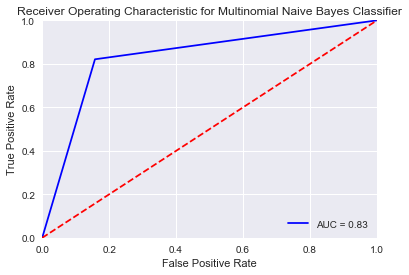

In [137]:
# Converting pos and neg labels to 1 and 0 respectively
y_test_for_roc = [1 if i == 'pos' else 0 for i in y_test]
preds_for_roc_mnb = [1 if i == 'pos' else 0 for i in preds]

#Calculating False Positive Rate,True Positive Rate and threshold
fpr_mnb, tpr_mnb, _ = metrics.roc_curve(y_test_for_roc, preds_for_roc_mnb)
roc_auc_mnb = metrics.auc(fpr_mnb, tpr_mnb)
#AUC is the percentage of the ROC plot that is underneath the curve:

plt.title('Receiver Operating Characteristic for Multinomial Naive Bayes Classifier')
plt.plot(fpr_mnb, tpr_mnb, 'b', label = 'AUC = %0.2f' % roc_auc_mnb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## ROC and AUC plot for Bernoulli Naive Bayes Classifier

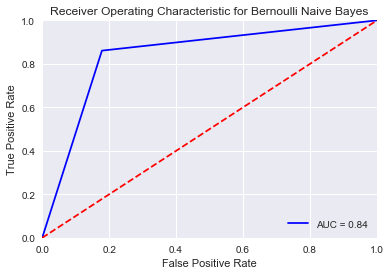

In [138]:
# Converting pos and neg labels to 1 and 0 respectively

y_test_for_roc = [1 if i == 'pos' else 0 for i in y_test]
preds_bnb_for_roc = [1 if i == 'pos' else 0 for i in preds_bnb]

#Calculating False Positive Rate,True Positive Rate and threshold
fpr_bnb, tpr_bnb, _ = metrics.roc_curve(y_test_for_roc, preds_bnb_for_roc)
roc_auc_bnb = metrics.auc(fpr_bnb, tpr_bnb)

#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for Bernoulli Naive Bayes')
plt.plot(fpr_bnb, tpr_bnb, 'b', label = 'AUC = %0.2f' % roc_auc_bnb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ROC and AUC plot for Linear Support Vector Classifier

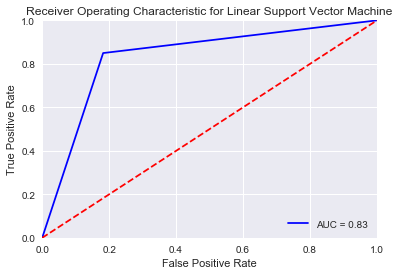

In [139]:
# Converting pos and neg labels to 1 and 0 respectively
#Calculating False Positive Rate,True Positive Rate and threshold
y_test_for_roc = [1 if i == 'pos' else 0 for i in y_test]
preds_linearsvc_for_roc = [1 if i == 'pos' else 0 for i in preds_linearsvc]

#Calculating False Positive Rate,True Positive Rate and threshold
fpr_lsvc, tpr_lsvc, _ = metrics.roc_curve(y_test_for_roc, preds_linearsvc_for_roc)
roc_auc_lsvc = metrics.auc(fpr_lsvc, tpr_lsvc)

#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for Linear Support Vector Machine')
plt.plot(fpr_lsvc, tpr_lsvc, 'b', label = 'AUC = %0.2f' % roc_auc_lsvc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ROC and AUC plot for Logistic Regression Classifier

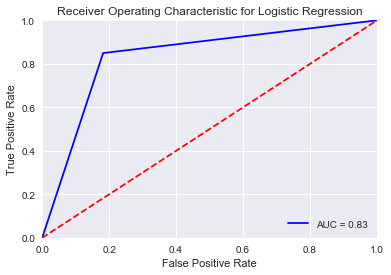

In [140]:
# Converting pos and neg labels to 1 and 0 respectively

y_test_for_roc = [1 if i == 'pos' else 0 for i in y_test]
preds_logreg_for_roc = [1 if i == 'pos' else 0 for i in preds_linearsvc]

#Calculating False Positive Rate,True Positive Rate and threshold
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_test_for_roc, preds_logreg_for_roc)
roc_auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)

#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.plot(fpr_logreg, tpr_logreg, 'b', label = 'AUC = %0.2f' % roc_auc_logreg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Here, we can see that the Bernoulli Naive Bayes Classifier has the highest value of AUC of 84%, we can conclude that **Bernoulli Naive Bayes Classifier is relatively better model which can be used to perform sentiment analysis on Amazon Reviews.**